# Analyze Region 10 - Asia, North

This notebook analyzes the largest glaciers, ice caps, and ice fields in Region 10 - Asia, North.

This region was deemed as needing a glacier complex analysis (ice caps and icefields), so note that the abbreviation "ic" stands for ice catchment aka glacier complex.

In [1]:
import os
import os.path as op
import glob
import sys
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
from rasterio.plot import plotting_extent
from earthpy import clip as cl
import earthpy.plot as ep

# set working dir
HOME = op.join(op.expanduser("~"))
os.chdir(os.path.join(HOME, "git/wgms-glacier-project"))

# Set up path to load scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.wgms_scripts as ws

# Set Up Region Info

In [2]:
# Set region number, region name, and region index
# Once these are set, this notebook should run automatically for the specified region
region_number = "10"
region_name = "Asia, North"

# The variable primeclass needs to be updated with the primary class of the ice complexes for the region
# This may need to be a list in some instances
# 2: icefield, 3: ice cap, 4: outlet glacier, 5: valley glacier, 6: mountain glacier
primeclass1 = 4 # This was not already set in GLIMS but based it on what Michael Zemp said
primeclass2 = 5 # This was not already set in GLIMS but based it on what Michael Zemp said
primeclass3 = 6 # This was not already set in GLIMS but based it on what the WGI said

# Note for the region index, region_index_1 should be one less than the region number and 
# region_index_2 should be equal to the region number. For example, for region 1, index_1 should be set to 0 and 
# index_2 should be set to 1, etc.
region_index_1 = 9
region_index_2 = 10

# Ice cap/icefield epsg code used for calculating area
#ic_epsg = '102025'

# This variable sets a value to determine whether the differences between the GLIMS and RGI glacier have been checked.
# When first starting a new notebook set handled to 0
# Once the differences have been checked and handled, set to 1 to pass the check 
# in the Compare Glaciers from GLIMS and RGI section towards the middele of this notebook.
handled = 1

# * * * * * * * * Show Region Outline * * * * * * * *

In [3]:
# Open natural earth basemap TIF file
ne_fp = 'data/natural-earth/NE1_HR_LC_SR_W/NE1_HR_LC_SR_W.tif' # 10 m res
with rio.open(ne_fp) as ne_src:
    # Convert / read the data into a numpy array:
    ne_raster = ne_src.read()
    ne_src_extent = plotting_extent(ne_src)
    bounds = ne_src.bounds
    ne_raster_meta = ne_src.meta

In [4]:
# Open glacier regions
glacier_regions_fp = "data/gtn-g-glacier-regions/cleaned/GTN-G_glacier_regions_201707_cleaned.shp"
glacier_regions = gpd.read_file(glacier_regions_fp)

# Extract Region outline
region_outline = glacier_regions[region_index_1:region_index_2]

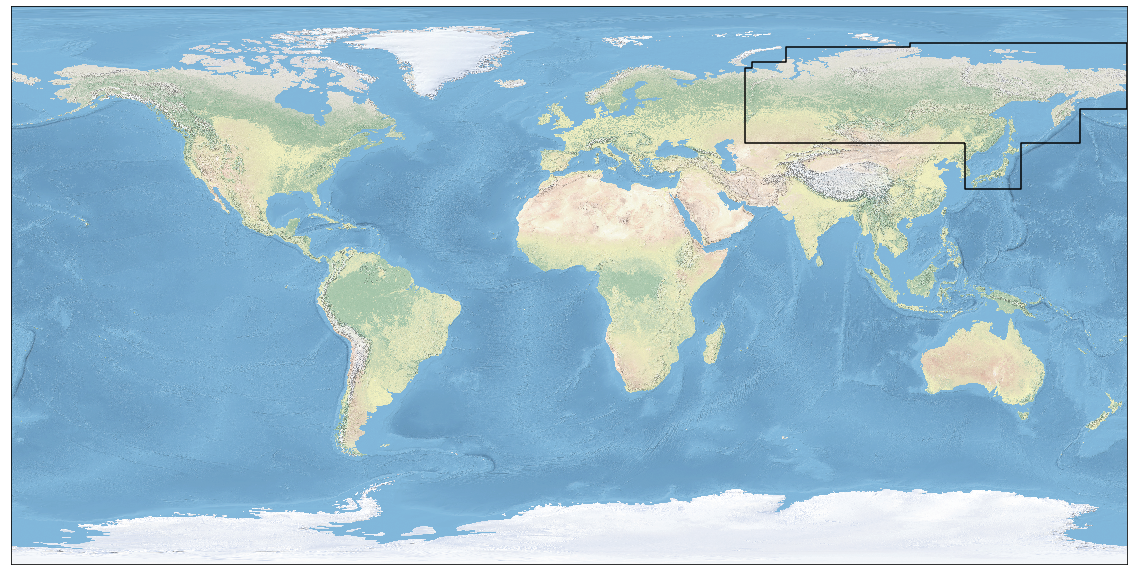

In [5]:
# Plot region outline over the natural earth
# Plot natural earth basemap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot natural earth
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot region outline
region_outline.boundary.plot(ax=ax, color="black")

plt.show()

In [6]:
region_outline.bounds

minx  miny   maxx  maxy
9  57.0  31.0  180.0  78.0

# * * * * * * * * Glacier Analysis * * * * * * * *

## Open GLIMS 3 Largest Glaciers Data

In [7]:
# Open GLIMS three largest glacier outlines for this region.
glims_glaciers_fn = "data/glims/processed/largest/glims_region_" + region_number + "_largest.shp"
glims_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [8]:
# Check if GLIMS glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
glims_df_len = len(glims_glaciers_df)
for x in range(glims_df_len):
    if glims_glaciers_df['glac_name'][x] == None:
        print("GLIMS glacier " + str(x) + " equals none")
        glims_glaciers_df.loc[x, 'glac_name'] = 'NONE'

In [9]:
glims_glaciers_df

region_no         glac_id    area  db_area  width  length  primeclass  \
0         10  G148920E76680N  48.144  48.1442    0.0     0.0         0.0   
1         10  G087851E49154N  37.323  37.3957    0.0     0.0         0.0   
2         10  G160564E57830N  33.714  33.7142    0.0     0.0         0.0   
3         10  G160561E56087N  33.481  33.4809    0.0     0.0         0.0   
4         10  G087783E49100N  23.955  23.9553    0.0     0.0         0.0   

   min_elev  mean_elev  max_elev             src_date  \
0      40.0        0.0     380.0  1956-05-15T00:00:00   
1    2913.0        0.0    4317.0  2011-08-23T00:00:00   
2     946.0        0.0    1908.0  2011-08-03T00:00:00   
3    1103.0        0.0    3852.0  2011-08-03T00:00:00   
4    2507.0        0.0    4319.0  2011-08-23T00:00:00   

                                          glac_name  \
0  SU5E17701002 Toll Ice Cap                      ?   
1                                              None   
2                                              None   
3                                              None   
4                                    Kanasi Glacier   

                                            geometry  
0  POLYGON Z ((149.07254 76.67994899999999 0, 149...  
1  POLYGON Z ((87.823842 49.178093 0, 87.82388400...  
2  POLYGON Z ((160.561655 57.84762 0, 160.561149 ...  
3  POLYGON Z ((160.513231 56.097518 0, 160.513263...  
4  POLYGON Z ((87.827422 49.135559 0, 87.82906699...

## Open RGI 3 Largest Glaciers Data

In [10]:
# Open RGI three largest glacier outlines for this region.
rgi_glaciers_fn = "data/rgi/processed/largest/rgi_region_" + region_number + "_largest.shp"
rgi_glaciers_df = gpd.read_file(rgi_glaciers_fn)

In [11]:
# Check if RGI glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
rgi_df_len = len(rgi_glaciers_df)
for x in range(rgi_df_len):
    if rgi_glaciers_df['Name'][x] == None:
        print("RGI glacier " + str(x) + " equals none")
        rgi_glaciers_df.loc[x, 'Name'] = 'NONE'

RGI glacier 1 equals none
RGI glacier 2 equals none
RGI glacier 3 equals none
RGI glacier 4 equals none


In [12]:
rgi_glaciers_df

RGIId         GLIMSId   BgnDate   EndDate      CenLon     CenLat  \
0  RGI60-10.00002  G148920E76680N  19560599  19560999  148.920000  76.680000   
1  RGI60-10.02000  G087857E49157N  20110823  -9999999   87.856636  49.156937   
2  RGI60-10.04181  G160564E57830N  20110803  -9999999  160.564331  57.830070   
3  RGI60-10.04024  G160561E56087N  20110803  -9999999  160.561066  56.086594   
4  RGI60-10.01997  G087840E49109N  20110823  -9999999   87.839622  49.108753   

  O1Region O2Region    Area  Zmin  ...  Aspect   Lmax  Status  Connect  Form  \
0       10        2  48.144     0  ...     185   4900       2        0     1   
1       10        4  37.323  2915  ...      75  12001       0        0     0   
2       10        5  33.714   946  ...     254   9205       0        0     0   
3       10        5  33.481  1103  ...      43  21922       0        0     0   
4       10        4  23.955  2507  ...     328   9990       0        0     0   

   TermType  Surging  Linkages                       Name  \
0         0        9         0  SU5E17701002 Toll Ice Cap   
1         0        9         9                       NONE   
2         0        9         9                       NONE   
3         0        9         9                       NONE   
4         0        9         9                       NONE   

                                            geometry  
0  POLYGON ((148.9464210090001 76.64537134700004,...  
1  POLYGON ((87.84088046800008 49.17746101500006,...  
2  POLYGON ((160.5616545920001 57.84761960300006,...  
3  POLYGON ((160.647832844 56.09387418000006, 160...  
4  POLYGON ((87.83897694500007 49.13412628400005,...  

[5 rows x 23 columns]

## Plot GLIMS Glaciers

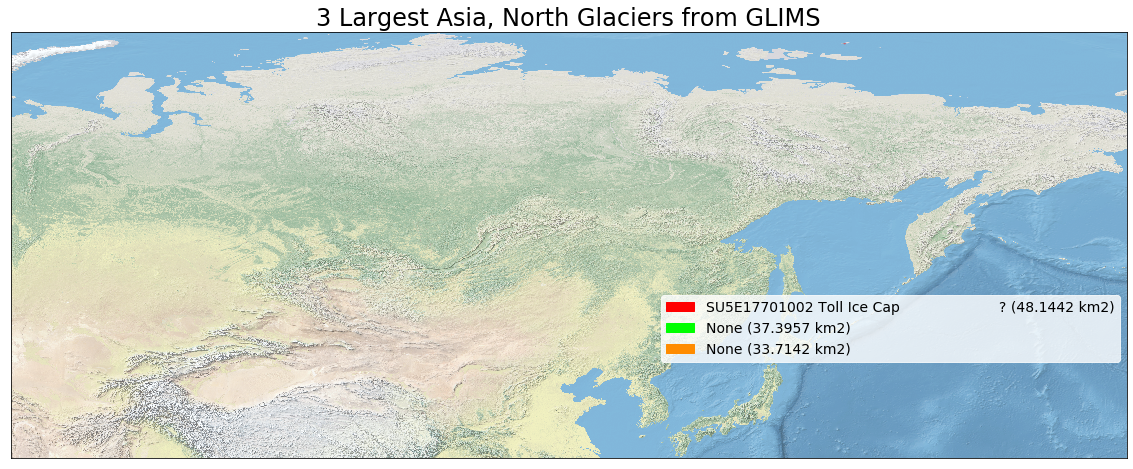

In [13]:
# Plot 3 largest glaciers on natural earth from GLIMS
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [glims_glaciers_df['glac_name'][0] + ' (' + str(glims_glaciers_df['db_area'][0]) + ' km2)',
                 glims_glaciers_df['glac_name'][1] + ' (' + str(glims_glaciers_df['db_area'][1]) + ' km2)',
                 glims_glaciers_df['glac_name'][2] + ' (' + str(glims_glaciers_df['db_area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
glims_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
glims_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
glims_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from GLIMS', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,0.4))

plt.show()

## Plot RGI Glaciers

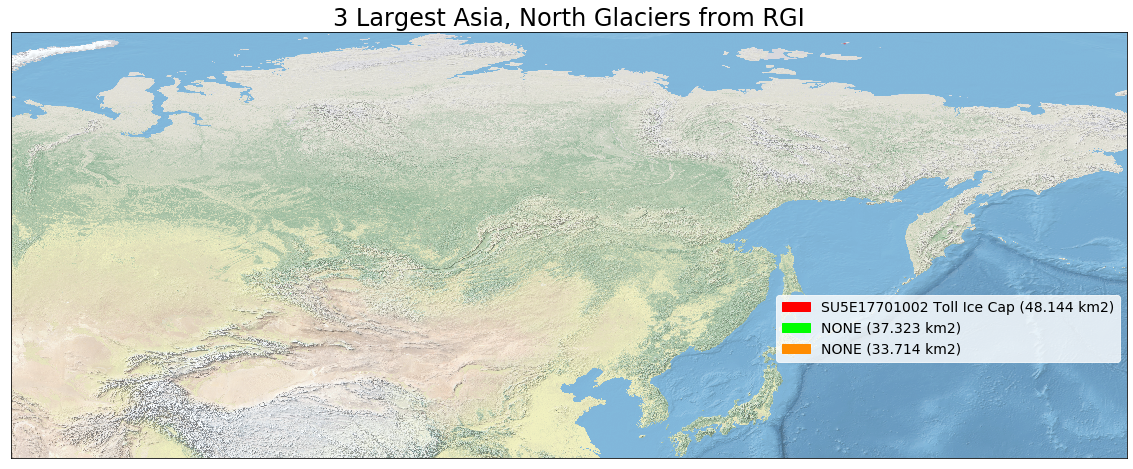

In [14]:
# Plot 3 largest glaciers on natural earth from RGI
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [rgi_glaciers_df['Name'][0] + ' (' + str(rgi_glaciers_df['Area'][0]) + ' km2)',
                 rgi_glaciers_df['Name'][1] + ' (' + str(rgi_glaciers_df['Area'][1]) + ' km2)',
                 rgi_glaciers_df['Name'][2] + ' (' + str(rgi_glaciers_df['Area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from rgi dataframe
rgi_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
rgi_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
rgi_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from RGI', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0, 0.4))

plt.show()

## Compare Glaciers from GLIMS and RGI
Do they match? If yes, continue, if no, stop notebook and investigate. Once the differences have been investigated and corrected in the code below this code block, set handled to 1 in the "Set Up Region Info" section at the top of the notebook, so that it passes this test.

In [15]:
if (glims_glaciers_df['glac_name'][0] == rgi_glaciers_df['Name'][0] and 
    glims_glaciers_df['glac_name'][1] == rgi_glaciers_df['Name'][1] and 
    glims_glaciers_df['glac_name'][2] == rgi_glaciers_df['Name'][2]):
    print("They match!")
else:
    if handled != 1:
        # If this hasn't been handled, stop execution
        class StopExecution(Exception):
            def _render_traceback_(self):
                pass

        print("They do NOT Match! Stopping notebook.")
        raise StopExecution
    else:
        # If this has been handled, continue execution
        print("They do not match but this has been handled in the code below this section, so continue.")

They do not match but this has been handled in the code below this section, so continue.


## Create Final Glacier Shapefiles
This section creates and formats the final glacier dataframe, plots it to make sure it looks ok, and saves it to a shapefile.

Since the largest glacier in the GLIMS and RGI databases is actually an ice cap (Toll), skipping that one and using the next 3 entries as the the 3 largest glaciers.

Check WGI for primary classification

Locations of these glaciers:
* Toll Ice Cap (G148920E76680N) - Located on Bennett Island, which is the far northeast corner of Russian mainland (Kotlyakov, 2010)
* G087851E49154N - Potanin Glacier (Kamp et al., 2013) located in Mongolia at the corner where Mongolia meets China, Russia, and Kazakhstan in the Tavan Bogd Massif in the Mongol-Altai Mountains. No entry for this in WGI, I'm calling it a primary class of 6.
* G160564E57830N - Slunina Glacier (Khromova et al., 2014) located on Kamchatka Peninsula in very far northwest Russia in the Sredinny Range. WGI says primary class is 6 (SU5F20004085). 
* G160561E56087N - No name (Muraviev, 2016) located on Kamchatka Peninsula in very far northwest Russia on Ushkovsky volcano. WGI doesn't exactly have an entry for this but a small area off to the side of the glacier (SU5F20003158) says primary class of 5. I think it's more likely a 6.

### Create final glacier dataframe

In [16]:
# Set up the final dataframe that will be used when saving the final shapefiles
# Drop columns that are not needed for the final data (use GLIMS dataframe for this)
final_glacier_data_df = glims_glaciers_df.drop(['area', 'width', 'length', 
                                                'min_elev', 'mean_elev', 'max_elev'], axis=1)

# Add region_name column
final_glacier_data_df['reg_name'] = region_name

# Rename some columns
final_glacier_data_df.rename(columns={'glac_id': 'glims_id', 'db_area': 'area_km2', 
                                       'src_date': 'date'}, inplace=True)

# Drop first and last rows because the first row is an ice cap and the last row is the 4th largest glacier so we
# aren't interested in them
final_glacier_data_df.drop([0, 4], inplace = True)

# Add RGI ID column
final_glacier_data_df['rgi_id'] = (rgi_glaciers_df['RGIId'][1], rgi_glaciers_df['RGIId'][2], 
                                   rgi_glaciers_df['RGIId'][3])

# Add area_src column that gets filled lower down
final_glacier_data_df['area_src'] = '-999'

# Add primary class (primeclass) column. 
final_glacier_data_df['primeclass'] = [primeclass2, primeclass3, primeclass1]

# Reorder the columns of the dataframe
final_glacier_data_df = final_glacier_data_df[['region_no', 'reg_name', 'glac_name', 'glims_id', 'rgi_id', 
                                               'primeclass', 'area_km2', 'area_src', 'date', 'geometry']]

In [17]:
final_glacier_data_df

region_no     reg_name glac_name        glims_id          rgi_id  \
1         10  Asia, North      None  G087851E49154N  RGI60-10.02000   
2         10  Asia, North      None  G160564E57830N  RGI60-10.04181   
3         10  Asia, North      None  G160561E56087N  RGI60-10.04024   

   primeclass  area_km2 area_src                 date  \
1           5   37.3957     -999  2011-08-23T00:00:00   
2           6   33.7142     -999  2011-08-03T00:00:00   
3           4   33.4809     -999  2011-08-03T00:00:00   

                                            geometry  
1  POLYGON Z ((87.823842 49.178093 0, 87.82388400...  
2  POLYGON Z ((160.561655 57.84762 0, 160.561149 ...  
3  POLYGON Z ((160.513231 56.097518 0, 160.513263...

In [18]:
# Calculate area and update dataframe as neccessary and clean the date format in the date column
# If GLIMS and RGI dates are the same year, then average the two areas.
# If GLIMS date is more recent, then use that average.
# If RGI date is more recent, then use that average. (Note I don't think this ever happens)
# Note only comparing by year because sometimes the month and day are not known. Year matching is close enough.
# Since skipping the first entry in both GLIMS and RGI because it is an ice cap, adding a 1 to the index
for x in range(3):
    # Exract and clean GLIMS date so that it is comparable to RGI date
    glims_date = glims_glaciers_df['src_date'][x+1][0:10].replace('-', '')
    glims_year = glims_date[0:4]
    print('glims date: ' + glims_date)
    #print('glims year: ' + glims_year)
    
    # Extract RGI date
    rgi_date = rgi_glaciers_df['BgnDate'][x+1]
    rgi_year = rgi_date[0:4]
    print('rgi date: ' + rgi_date)
    #print('rgi year: ' + rgi_year)
    
    if glims_year == rgi_year:
        # Average GLIMS and RGI areas
        area = np.average([glims_glaciers_df['db_area'][x+1], rgi_glaciers_df['Area'][x+1]])
        area_src = 'A'
        print('Averaging area: ' + str(area))
    elif glims_year > rgi_year:
        # Use GLIMS area for the area
        area = glims_glaciers_df['db_area'][x+1]
        area_src = 'G'
        print('Using GLIMS area: ' + str(area))
    elif rgi_year > glims_year:
        # Use RGI area for the area
        area = rgi_glaciers_df['Area'][x+1]
        area_src = 'R'
        print('Using RGI area: ' + str(area))
    else:
        print("Error. Area could not be calculated.")
    
    print('')
    # Set the area in the final dataframe
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('area_km2')] = area
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('area_src')] = area_src
    
    # Clean the date format in the final dataframe
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('date')] = \
        glims_glaciers_df['src_date'][x+1][0:10]
    
    # Set the glacier names and primeclass manually for the final data df
    if x == 0:
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = "Potanin Glacier"
    if x == 1:   
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = "Slunina Glacier"
    if x == 2:
        # Name from Barr (2018)
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = "Erman Glacier"
        
# Reset index
final_glacier_data_df = final_glacier_data_df.reset_index(drop=True)

glims date: 20110823
rgi date: 20110823
Averaging area: 37.35935

glims date: 20110803
rgi date: 20110803
Averaging area: 33.7141

glims date: 20110803
rgi date: 20110803
Averaging area: 33.48095



In [19]:
final_glacier_data_df

region_no     reg_name        glac_name        glims_id          rgi_id  \
0         10  Asia, North  Potanin Glacier  G087851E49154N  RGI60-10.02000   
1         10  Asia, North  Slunina Glacier  G160564E57830N  RGI60-10.04181   
2         10  Asia, North    Erman Glacier  G160561E56087N  RGI60-10.04024   

   primeclass  area_km2 area_src        date  \
0           5  37.35935        A  2011-08-23   
1           6  33.71410        A  2011-08-03   
2           4  33.48095        A  2011-08-03   

                                            geometry  
0  POLYGON Z ((87.823842 49.178093 0, 87.82388400...  
1  POLYGON Z ((160.561655 57.84762 0, 160.561149 ...  
2  POLYGON Z ((160.513231 56.097518 0, 160.513263...

### Plot final glacier dataframe to check accuracy

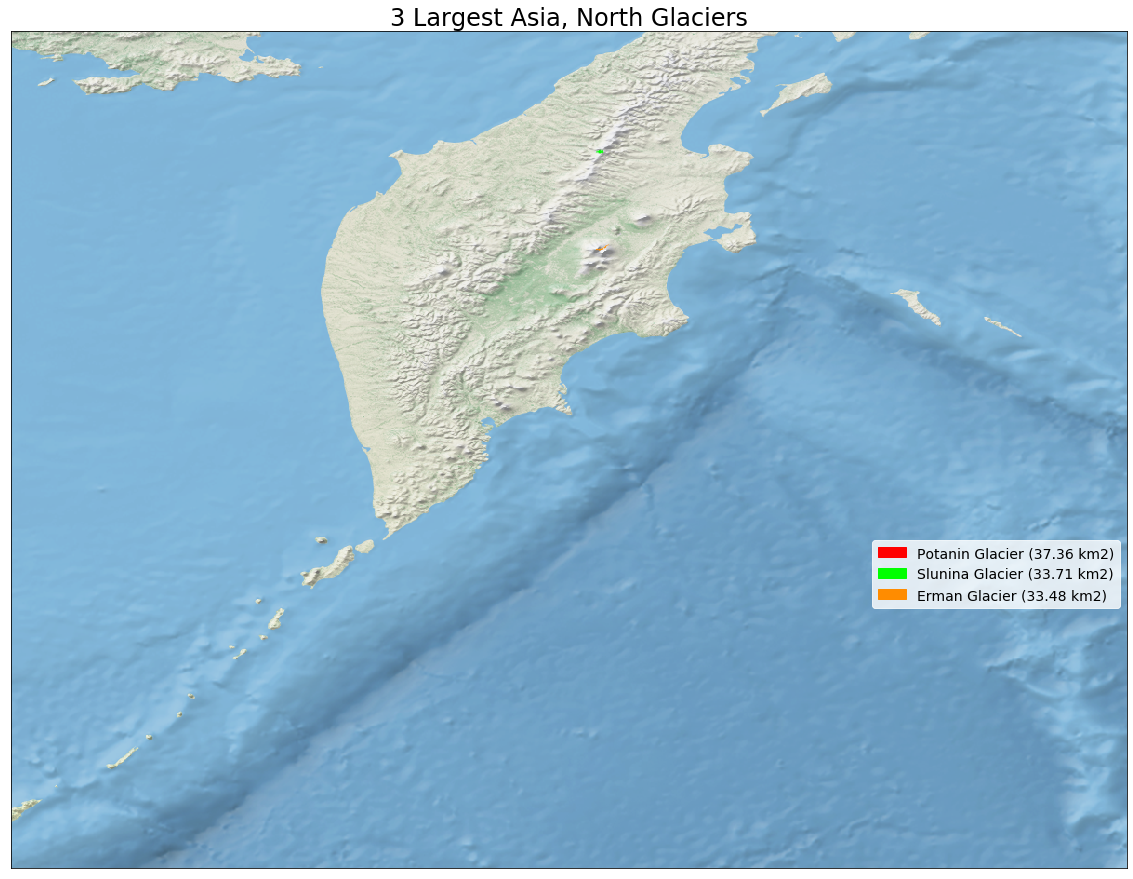

In [35]:
# Check that the geodataframe wasn't corrupted from these changes by plotting the data
# Plot 3 largest glaciers on natural earth from GLIMS
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [final_glacier_data_df['glac_name'][0] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][0], 2)) + ' km2)',
                 final_glacier_data_df['glac_name'][1] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][1], 2)) + ' km2)',
                 final_glacier_data_df['glac_name'][2] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Zoom
minx = 150
maxx = 170
miny = 45
maxy = 60
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
final_glacier_data_df.iloc[0:1].plot(ax=ax, color='red')
final_glacier_data_df.iloc[1:2].plot(ax=ax, color='lime')
final_glacier_data_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,0.4))

plt.show()

### Create largest glacier shapefile from the final glacier dataframe

In [21]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
glacier_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.zip"
if os.path.exists(glacier_zipfile_fn) == False:
    # Create the shapefile
    final_glacier_data_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.shp"
    final_glacier_data_df.to_file(driver='ESRI Shapefile', filename=final_glacier_data_fn)
    
    # Zip up the shapefile
    glacier_zipfile_fn = ws.zipshp(final_glacier_data_fn, Delete=True)
    print("Creating zipfile: " + glacier_zipfile_fn)
else:
    print(glacier_zipfile_fn + " already extists")

Creating zipfile: data/final-dataset\region-10-largest-glaciers.zip


# * * * * * * * * Ice Cap Analysis * * * * * * * *

This region really only has one ice cap (Toll Ice Cap) but the following code reveals some ice fields.

In [22]:
# Open this regions ice caps from the exploded version
ice_caps_ex_fn = "data/glims/processed/ice-caps/largest/largest-ice-caps-region_" + region_number + "_laea.shp"
ice_caps_ex_df = gpd.read_file(ice_caps_ex_fn)

In [23]:
ice_caps_ex_df

id        area                                           geometry
0     9  136.988783  POLYGON ((87.95810299999999 49.065968, 87.9580...
1    50  123.042869  POLYGON ((160.613763 56.033431, 160.613752 56....
2    65  114.397769  POLYGON ((160.817577 58.130983, 160.817563 58....
3   118   86.023890  POLYGON ((87.70047 50.02068, 87.700137 50.0206...
4    43   84.429925  POLYGON ((86.55569800000001 49.772083, 86.5561...
5    10   68.513702  POLYGON ((87.310936 49.082513, 87.310934 49.08...
6  2521   61.590648  POLYGON ((87.78063400000001 49.767304, 87.7806...
7  5211   48.801534  POLYGON ((149.0384 76.64999400000001, 149.0381...
8    63   43.104484  POLYGON ((160.788032 58.00904, 160.787965 58.0...
9    72   38.566327  POLYGON ((160.625996 57.850854, 160.625923 57....

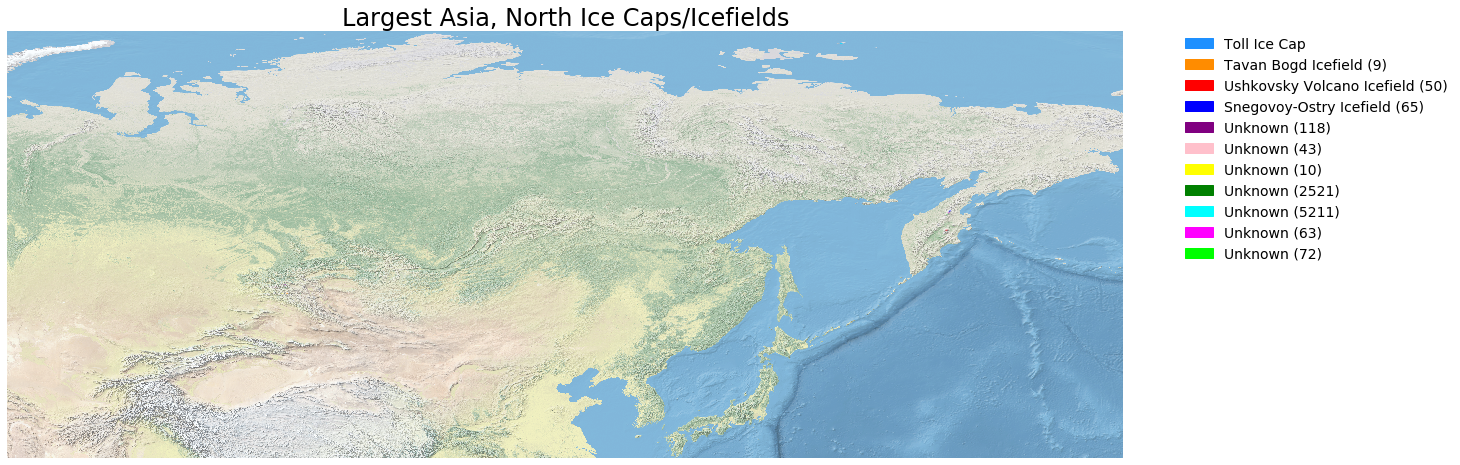

In [24]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['dodgerblue', 'darkorange', 'red', 'blue', 'purple', 'pink', 'yellow', 'green', 
                 'cyan', 'magenta', 'lime']
legend_labels = ['Toll Ice Cap', 'Tavan Bogd Icefield (9)', 'Ushkovsky Volcano Icefield (50)', 
                 'Snegovoy-Ostry Icefield (65)', 
                 'Unknown (118)', 'Unknown (43)', 'Unknown (10)', 'Unknown (2521)', 
                 'Unknown (5211)', 'Unknown (63)', 'Unknown (72)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
# Adding Toll Ice Cap from GLIMS
glims_glaciers_df.iloc[0:1].plot(ax=ax, color='dodgerblue')
ice_caps_ex_df.iloc[0:1].plot(ax=ax, color="darkorange")
ice_caps_ex_df.iloc[1:2].plot(ax=ax, color="red")
ice_caps_ex_df.iloc[2:3].plot(ax=ax, color="blue")
ice_caps_ex_df.iloc[3:4].plot(ax=ax, color="purple")
ice_caps_ex_df.iloc[4:5].plot(ax=ax, color="pink")
ice_caps_ex_df.iloc[5:6].plot(ax=ax, color="yellow")
ice_caps_ex_df.iloc[6:7].plot(ax=ax, color="green")
ice_caps_ex_df.iloc[7:8].plot(ax=ax, color="cyan")
ice_caps_ex_df.iloc[8:9].plot(ax=ax, color="magenta")
ice_caps_ex_df.iloc[9:10].plot(ax=ax, color="lime")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

## Create Final Ice Catchment Data Frame
This ice catchment data frame will then be saved to a shapefile.

For the icefields, these don't really have names, so will need to ask correspondant how they feel about the names I'm giving them and if these are really icefields. Toll Ice cap is in this region on Bennet Island north of the Russian mainland but it's very small compared to these top 3 so will not be including it in the final analysis. Can add it from the GLIMS database if desired.

The top 3 icefields in ice_caps_ex_df:

* ID 9 - "Tavan Bogd Icefield" located in Mongolia at the corner where Mongolia meets China, Russia, and Kazakhstan in the Tavan Bogd Massif in the Mongol-Altai Mountains.
* ID 50 - "Ushkovsky Volcano Icefield" located on Kamchatka Peninsula
* ID 65 - "Snegovoy-Ostry Icefield" located on Kamchatka Peninsula

In [25]:
# Update and reorganize ice_caps_ex_df to create final df
# Drop uneeded columns
final_catchment_data_df = ice_caps_ex_df.drop(['id'], axis=1)

# Drop last 7 rows because only interested in the top 3 ice caps and icefields
final_catchment_data_df.drop([3, 4, 5, 6, 7, 8, 9], inplace = True)

# Add Toll Ice Cap from GLIMS database
#final_catchment_data_df = final_catchment_data_df.append(glims_glaciers_df.iloc[0:1].drop(['region_no',
#                                                                                           'glac_id', 
#                                                                                           'db_area', 
#                                                                                           'width',
#                                                                                           'length',
#                                                                                           'primeclass',
#                                                                                           'min_elev',
#                                                                                           'max_elev',
#                                                                                           'mean_elev',
#                                                                                           'src_date',
#                                                                                           'glac_name'], axis=1))


# Add region_no column
final_catchment_data_df['region_no'] = region_number

# Add region_name column
final_catchment_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_catchment_data_df['primeclass'] = [2, 2, 2] #, 3] # For Toll Ice Cap

# Add catchment names
final_catchment_data_df['ic_name'] = ['Tavan Bogd Icefield', 'Ushkovsky Volcano Icefield', 
                                      'Snegovoy-Ostry Icefield'] #, 'Toll Ice Cap']

### Get ice catchment measurement dates from a range of glacier outline dates.

In [26]:
# Open GLIMS shapefile with all of the glacier outlines
glims_glaciers_fn = "data/glims/processed/cleaned/glims_region_" + region_number + "_cleaned.shp"
glims_all_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [27]:
# The call to the pip function can take a couple of minutes to many hours to run depending on the complexity and size
# of the ice catchment outline. I set up the code to save the output to shapefiles that can be read in more quickly
# if desired. However, you can toggle whether you read the files or run the pip command with the following variable.
# Note that you must run the pip command the first time this code is run in order to create the shapefiles.
run_code = 0 # set to 0 to read from shapefiles, set to 1 to run pip command

# Get glaciers in the 1st largest glacier complex
if run_code == 1: # run pip command
    largest_ic_1_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[0:1].reset_index(drop=True), buffer_val=.001)
    largest_ic_1_glaciers = glims_all_glaciers_df.loc[largest_ic_1_mask]
    largest_ic_1_glaciers.reset_index(drop=True, inplace=True)
elif run_code == 0: # read saved shapefiles
    ic_1_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                        region_number + "-1st-largest-ic-glacier-outlines.zip"
    with zipfile.ZipFile(ic_1_glaciers_zfn,"r") as zip_ref:
        zip_ref.extractall("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped")

    ic_1_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-" + \
                                  region_number + "-1st-largest-ic-glacier-outlines.shp"
    largest_ic_1_glaciers = gpd.read_file(ic_1_glaciers_shape_fn)
    print("Reading file " + ic_1_glaciers_shape_fn)

    # Clean up unzipped files to save disk space
    filelist = glob.glob("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/*")
    for f in filelist:
        os.remove(f)
else:
    print("Incorrect value for the run_code variable. Must be 0 or 1.")

# Clean and print the minimum date and the maximum date
largest_ic_1_min_date = largest_ic_1_glaciers['src_date'].min()[0:10]
largest_ic_1_max_date = largest_ic_1_glaciers['src_date'].max()[0:10]
print('1st largest start date: ' + largest_ic_1_min_date)
print('1st largest end date: ' + largest_ic_1_max_date)
print('')

# Get all glims ids that make up the 1st largest ice catchment
largest_ic_1_glims_ids = largest_ic_1_glaciers['glac_id']
for i in range(len(largest_ic_1_glims_ids)):
    if i == 0:
        all_largest_ic_1_ids = largest_ic_1_glims_ids[i]
    else:
        all_largest_ic_1_ids = all_largest_ic_1_ids + ', ' + largest_ic_1_glims_ids[i]

# Get glaciers in the 2nd largest glacier complex
if run_code == 1: # run pip command
    largest_ic_2_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[1:2].reset_index(drop=True))
    largest_ic_2_glaciers = glims_all_glaciers_df.loc[largest_ic_2_mask]
    largest_ic_2_glaciers.reset_index(drop=True, inplace=True)
elif run_code == 0: # read saved shapefiles
    ic_2_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                        region_number + "-2nd-largest-ic-glacier-outlines.zip"
    with zipfile.ZipFile(ic_2_glaciers_zfn,"r") as zip_ref:
        zip_ref.extractall("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped")

    ic_2_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-" + \
                                  region_number + "-2nd-largest-ic-glacier-outlines.shp"
    largest_ic_2_glaciers = gpd.read_file(ic_2_glaciers_shape_fn)
    print("Reading file " + ic_2_glaciers_shape_fn)

    # Clean up unzipped files to save disk space
    filelist = glob.glob("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/*")
    for f in filelist:
        os.remove(f)
else:
    print("Incorrect value for the run_code variable. Must be 0 or 1.")

# Clean and print the minimum date and the maximum date
largest_ic_2_min_date = largest_ic_2_glaciers['src_date'].min()[0:10]
largest_ic_2_max_date = largest_ic_2_glaciers['src_date'].max()[0:10]
print('2nd largest start date: ' + largest_ic_2_min_date)
print('2nd largest end date: ' + largest_ic_2_max_date)
print('')

# Get all glims ids that make up the 2nd largest ice catchment
largest_ic_2_glims_ids = largest_ic_2_glaciers['glac_id']
for i in range(len(largest_ic_2_glims_ids)):
    if i == 0:
        all_largest_ic_2_ids = largest_ic_2_glims_ids[i]
    else:
        all_largest_ic_2_ids = all_largest_ic_2_ids + ', ' + largest_ic_2_glims_ids[i]


# Get glaciers in the 3rd largest glacier complex
if run_code == 1: # run pip command
    largest_ic_3_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[2:3].reset_index(drop=True))
    largest_ic_3_glaciers = glims_all_glaciers_df.loc[largest_ic_3_mask]
    largest_ic_3_glaciers.reset_index(drop=True, inplace=True)
elif run_code == 0: # read saved shapefiles
    ic_3_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                        region_number + "-3rd-largest-ic-glacier-outlines.zip"
    with zipfile.ZipFile(ic_3_glaciers_zfn,"r") as zip_ref:
        zip_ref.extractall("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped")

    ic_3_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-" + \
                                  region_number + "-3rd-largest-ic-glacier-outlines.shp"
    largest_ic_3_glaciers = gpd.read_file(ic_3_glaciers_shape_fn)
    print("Reading file " + ic_3_glaciers_shape_fn)

    # Clean up unzipped files to save disk space
    filelist = glob.glob("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/*")
    for f in filelist:
        os.remove(f)
else:
    print("Incorrect value for the run_code variable. Must be 0 or 1.")

# Clean and print the minimum date and the maximum date
largest_ic_3_min_date = largest_ic_3_glaciers['src_date'].min()[0:10]
largest_ic_3_max_date = largest_ic_3_glaciers['src_date'].max()[0:10]
print('3rd largest start date: ' + largest_ic_3_min_date)
print('3rd largest end date: ' + largest_ic_3_max_date)
print('')

# Get all glims ids that make up the 3rd largest ice catchment
largest_ic_3_glims_ids = largest_ic_3_glaciers['glac_id']
for i in range(len(largest_ic_3_glims_ids)):
    if i == 0:
        all_largest_ic_3_ids = largest_ic_3_glims_ids[i]
    else:
        all_largest_ic_3_ids = all_largest_ic_3_ids + ', ' + largest_ic_3_glims_ids[i]

Reading file data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-10-1st-largest-ic-glacier-outlines.shp
1st largest start date: 1989-09-03
1st largest end date: 2011-08-23

Reading file data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-10-2nd-largest-ic-glacier-outlines.shp
2nd largest start date: 2011-08-03
2nd largest end date: 2011-08-03

Reading file data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-10-3rd-largest-ic-glacier-outlines.shp
3rd largest start date: 2000-07-18
3rd largest end date: 2000-07-18



In [28]:
# Add the dates to the dataframe
final_catchment_data_df['min_date'] = [largest_ic_1_min_date, largest_ic_2_min_date, largest_ic_3_min_date]

final_catchment_data_df['max_date'] = [largest_ic_1_max_date, largest_ic_2_max_date, largest_ic_3_max_date]

# Reorder the columns
final_catchment_data_df = final_catchment_data_df[['region_no', 'reg_name', 'ic_name', 'primeclass', 'area', 
                                                   'min_date', 'max_date', 'geometry']]

# Rename the area column
final_catchment_data_df.rename(columns={'area': 'area_km2'}, inplace=True)
                                     
# Reset index
final_catchment_data_df = final_catchment_data_df.reset_index(drop=True)

In [29]:
final_catchment_data_df

region_no     reg_name                     ic_name  primeclass    area_km2  \
0        10  Asia, North         Tavan Bogd Icefield           2  136.988783   
1        10  Asia, North  Ushkovsky Volcano Icefield           2  123.042869   
2        10  Asia, North     Snegovoy-Ostry Icefield           2  114.397769   

     min_date    max_date                                           geometry  
0  1989-09-03  2011-08-23  POLYGON ((87.95810299999999 49.065968, 87.9580...  
1  2011-08-03  2011-08-03  POLYGON ((160.613763 56.033431, 160.613752 56....  
2  2000-07-18  2000-07-18  POLYGON ((160.817577 58.130983, 160.817563 58....

### Plot the final catchment dataframe to verify it looks correct

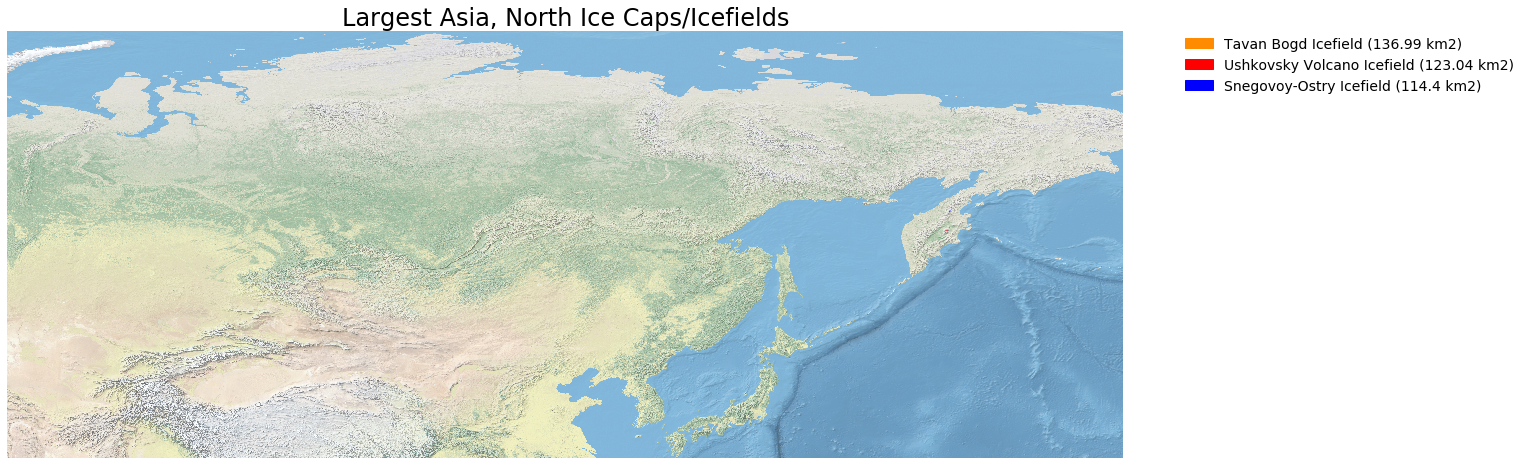

In [30]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue', 'green']
legend_labels = [final_catchment_data_df['ic_name'][0] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][0], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][1] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][1], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][2] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][2], 2)) + ' km2)']
                 #final_catchment_data_df['ic_name'][3] + \
                 #' (' + str(round(final_catchment_data_df['area_km2'][3], 3)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
final_catchment_data_df.iloc[0:1].plot(ax=ax, color="darkorange")
final_catchment_data_df.iloc[1:2].plot(ax=ax, color="red")
final_catchment_data_df.iloc[2:3].plot(ax=ax, color="blue")
#final_catchment_data_df.iloc[3:4].plot(ax=ax, color="green")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

### Save final catchment dataframe to a shapefile

In [31]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
catchment_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.zip"
if os.path.exists(catchment_zipfile_fn) == False:
    # Create the shapefile
    final_catchment_data_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.shp"
    final_catchment_data_df.to_file(driver='ESRI Shapefile', filename=final_catchment_data_fn)
    
    # Zip up the shapefile
    catchment_zipfile_fn = ws.zipshp(final_catchment_data_fn, Delete=True)
    print("Creating zipfile: " + catchment_zipfile_fn)
else:
    print(catchment_zipfile_fn + " already extists")

data/final-dataset/region-10-largest-complexes.zip already extists


In [32]:
# Save the glims ids to a text file because the text is too long to be saved to a shapefile
text_file_1st_fn = "data/final-dataset/region-" + region_number + "-1st-largest-glims-ids.txt"
if os.path.exists(text_file_1st_fn) == False:
    print("Creating text file: " + text_file_1st_fn)
    text_file = open(text_file_1st_fn, "w")
    n = text_file.write(all_largest_ic_1_ids)
    text_file.close()
else:
    print(text_file_1st_fn + " already extists")
    
text_file_2nd_fn = "data/final-dataset/region-" + region_number + "-2nd-largest-glims-ids.txt"
if os.path.exists(text_file_2nd_fn) == False:
    print("Creating text file: " + text_file_2nd_fn)
    text_file = open(text_file_2nd_fn, "w")
    n = text_file.write(all_largest_ic_2_ids)
    text_file.close()
else:
    print(text_file_2nd_fn + " already extists")
    
text_file_3rd_fn = "data/final-dataset/region-" + region_number + "-3rd-largest-glims-ids.txt"
if os.path.exists(text_file_3rd_fn) == False:
    print("Creating text file: " + text_file_3rd_fn)
    text_file = open(text_file_3rd_fn, "w")
    n = text_file.write(all_largest_ic_3_ids)
    text_file.close()
else:
    print(text_file_3rd_fn + " already extists")
    
# Save the glacier outline dataframes from the pip command to shapefiles for easier recall later because sometimes
# the pip command can take hours to run
ic_1_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                    region_number + "-1st-largest-ic-glacier-outlines.zip"
if os.path.exists(ic_1_glaciers_zfn) == False:
    # Create the shapefile
    ic_1_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                              region_number + "-1st-largest-ic-glacier-outlines.shp"
    largest_ic_1_glaciers.to_file(driver='ESRI Shapefile', filename=ic_1_glaciers_shape_fn)
    
    # Zip up the shapefile
    ic_1_glaciers_zfn = ws.zipshp(ic_1_glaciers_shape_fn, Delete=True)
    print("Creating zipfile: " + ic_1_glaciers_zfn)
else:
    print(ic_1_glaciers_zfn + " already extists")
    
ic_2_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                    region_number + "-2nd-largest-ic-glacier-outlines.zip"
if os.path.exists(ic_2_glaciers_zfn) == False:
    # Create the shapefile
    ic_2_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                              region_number + "-2nd-largest-ic-glacier-outlines.shp"
    largest_ic_2_glaciers.to_file(driver='ESRI Shapefile', filename=ic_2_glaciers_shape_fn)
    
    # Zip up the shapefile
    ic_2_glaciers_zfn = ws.zipshp(ic_2_glaciers_shape_fn, Delete=True)
    print("Creating zipfile: " + ic_2_glaciers_zfn)
else:
    print(ic_2_glaciers_zfn + " already extists")
    
ic_3_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                    region_number + "-3rd-largest-ic-glacier-outlines.zip"
if os.path.exists(ic_3_glaciers_zfn) == False:
    # Create the shapefile
    ic_3_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                              region_number + "-3rd-largest-ic-glacier-outlines.shp"
    largest_ic_3_glaciers.to_file(driver='ESRI Shapefile', filename=ic_3_glaciers_shape_fn)
    
    # Zip up the shapefile
    ic_3_glaciers_zfn = ws.zipshp(ic_3_glaciers_shape_fn, Delete=True)
    print("Creating zipfile: " + ic_3_glaciers_zfn)
else:
    print(ic_3_glaciers_zfn + " already extists")

data/final-dataset/region-10-1st-largest-glims-ids.txt already extists
data/final-dataset/region-10-2nd-largest-glims-ids.txt already extists
data/final-dataset/region-10-3rd-largest-glims-ids.txt already extists
data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-10-1st-largest-ic-glacier-outlines.zip already extists
data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-10-2nd-largest-ic-glacier-outlines.zip already extists
data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-10-3rd-largest-ic-glacier-outlines.zip already extists


### Extra Stuff: Checking if pip function needs a buffer
Due to tiny differences in vertices computed from the explode method used to find ice catchments, the pip function doesn't always return all glaceris that should be in that outline. This section analyses what size buffer is needed to capture all glacier outlines that reside in an ice catchment outline.

Only the 1st largest ice catchment needed a buffer. A buffer value of .001 was optimal. The buffer value was added to the pip call in the code above.

In [33]:
# Stop execution here. Run extra stuff manually if you want to run this code
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

print("Stopping notebook.")
raise StopExecution

Stopping notebook.


#### Check 1st largest

In [ ]:
# Plot the catchment outline
final_catchment_data_df.iloc[0:1].boundary.plot()

# Plot the outlines acquired from pip function
largest_ic_1_glaciers.boundary.plot()

# Compare area calculated from the catchment outline and the sum of the individual outlines acquired from pip function
print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[0:1][0])
print('Area from sum: ', largest_ic_1_glaciers['db_area'].sum())

# Calculate the difference and print a message based on the magnitude of the difference
area_diff_1 = final_catchment_data_df['area_km2'].iloc[0:1][0] - largest_ic_1_glaciers['db_area'].sum()
if (abs(area_diff_1)) <= .1:
    print("Areas match well! Area difference: ", abs(area_diff_1))
    match1 = 1
else:
    print("*** Areas do not match well. May need to add a buffer. Area difference:", abs(area_diff_1))
    match1 = 0

In [ ]:
# If the areas do not match need to try different buffer values to get best match
buffer_val = 0.001
if match1 == 0:
    # Trying a buffer on the within function to see if it captures more of the galcier outliness
    ic_1_explode_outline = ice_caps_ex_df.iloc[0:1].reset_index(drop=True)
    largest_ic_1_mask_test = glims_all_glaciers_df.buffer(0).within(ic_1_explode_outline.loc[0, 'geometry'].
                                                                    buffer(buffer_val))
    largest_ic_1_glaciers_test = glims_all_glaciers_df.loc[largest_ic_1_mask_test]
    largest_ic_1_glaciers_test.reset_index(drop=True, inplace=True)
    
    # Plot the new buffered glacier outlines
    largest_ic_1_glaciers_test.boundary.plot()
    
    # Compare area calculated from the catchment outline and the sum of the individual outlines 
    # acquired from pip function
    print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[0:1][0])
    print('Area from sum: ', largest_ic_1_glaciers_test['db_area'].sum())
    
    # Plot the new buffered glacier outlines against the ice catchment outline
    fig, ax = plt.subplots(figsize=(5, 5))
    largest_ic_1_glaciers_test.boundary.plot(ax=ax, color='red')
    final_catchment_data_df.iloc[0:1].boundary.plot(ax=ax, color='blue')

#### Check 2nd largest

In [ ]:
# Plot the catchment outline
final_catchment_data_df.iloc[1:2].boundary.plot()

# Plot the outlines acquired from pip function
largest_ic_2_glaciers.boundary.plot()

# Compare area calculated from the catchment outline and the sum of the individual outlines acquired from pip function
print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[1:2][1])
print('Area from sum: ', largest_ic_2_glaciers['db_area'].sum())

# Calculate the difference and print a message based on the magnitude of the difference
area_diff_2 = final_catchment_data_df['area_km2'].iloc[1:2][1] - largest_ic_2_glaciers['db_area'].sum()
if (abs(area_diff_2)) <= .001:
    print("Areas match well! Area difference: ", abs(area_diff_2))
    match2 = 1
else:
    print("*** Areas do not match well. May need to add a buffer. Area difference:", abs(area_diff_2))
    match2 = 0

In [ ]:
# If the areas do not match need to try different buffer values to get best match
buffer_val = 0
if match2 == 0:
    # Trying a buffer on the within function to see if it captures more of the galcier outliness
    ic_2_explode_outline = ice_caps_ex_df.iloc[1:2].reset_index(drop=True)
    largest_ic_2_mask_test = glims_all_glaciers_df.buffer(0).within(ic_2_explode_outline.loc[0, 'geometry'].
                                                                    buffer(buffer_val))
    largest_ic_2_glaciers_test = glims_all_glaciers_df.loc[largest_ic_2_mask_test]
    largest_ic_2_glaciers_test.reset_index(drop=True, inplace=True)
    
    # Plot the new buffered glacier outlines
    largest_ic_2_glaciers_test.boundary.plot()
    
    # Compare area calculated from the catchment outline and the sum of the individual outlines 
    #acquired from pip function
    print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[1:2][1])
    print('Area from sum: ', largest_ic_2_glaciers_test['db_area'].sum())
    
    # Plot the new buffered glacier outlines against the ice catchment outline
    fig, ax = plt.subplots(figsize=(5, 5))
    largest_ic_2_glaciers_test.boundary.plot(ax=ax, color='red')
    final_catchment_data_df.iloc[1:2].boundary.plot(ax=ax, color='blue')

#### Check 3rd largest

In [ ]:
# Plot the catchment outline
final_catchment_data_df.iloc[2:3].boundary.plot()

# Plot the outlines acquired from pip function
largest_ic_3_glaciers.boundary.plot()

# Compare area calculated from the catchment outline and the sum of the individual outlines 
# acquired from pip function
print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[2:3][2])
print('Area from sum: ', largest_ic_3_glaciers['db_area'].sum())

# Calculate the difference and print a message based on the magnitude of the difference
area_diff_3 = final_catchment_data_df['area_km2'].iloc[2:3][2] - largest_ic_3_glaciers['db_area'].sum()
if (abs(area_diff_3)) <= .001:
    print("Areas match well! Area difference: ", abs(area_diff_3))
    match3 = 1
else:
    print("*** Areas do not match well. May need to add a buffer. Area difference:", abs(area_diff_3))
    match3 = 0

In [ ]:
# If the areas do not match need to try different buffer values to get best match
buffer_val = 0
if match3 == 0:
    # Trying a buffer on the within function to see if it captures more of the galcier outliness
    ic_3_explode_outline = ice_caps_ex_df.iloc[2:3].reset_index(drop=True)
    largest_ic_3_mask_test = glims_all_glaciers_df.buffer(0).within(ic_3_explode_outline.loc[0, 'geometry'].
                                                                    buffer(buffer_val))
    largest_ic_3_glaciers_test = glims_all_glaciers_df.loc[largest_ic_3_mask_test]
    largest_ic_3_glaciers_test.reset_index(drop=True, inplace=True)
    
    # Plot the new buffered glacier outlines
    largest_ic_3_glaciers_test.boundary.plot()
    
    # Compare area calculated from the catchment outline and the sum of the individual outlines 
    # acquired from pip function
    print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[2:3][2])
    print('Area from sum: ', largest_ic_3_glaciers_test['db_area'].sum())
    
    # Plot the new buffered glacier outlines against the ice catchment outline
    fig, ax = plt.subplots(figsize=(5, 5))
    largest_ic_3_glaciers_test.boundary.plot(ax=ax, color='red')
    final_catchment_data_df.iloc[2:3].boundary.plot(ax=ax, color='blue')